# Imports

In [16]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline # Used to smoothen out data
import statsmodels.api as sm # Used later to estimate a team's "elo"
import matplotlib.pyplot as plt

# Reading in csvs

In [17]:
MRegularSeasonCompactResults = pd.read_csv('../../data/MRegularSeasonCompactResults.csv')
WRegularSeasonCompactResults = pd.read_csv('../../data/WRegularSeasonCompactResults.csv')
MRegularSeasonDetailedResults = pd.read_csv('../../data/MRegularSeasonDetailedResults.csv')
WRegularSeasonDetailedResults = pd.read_csv('../../data/WRegularSeasonDetailedResults.csv')
MNCAATourneyCompactResults = pd.read_csv('../../data/MNCAATourneyCompactResults.csv')
WNCAATourneyCompactResults = pd.read_csv('../../data/WNCAATourneyCompactResults.csv')
MNCAATourneyDetailedResults = pd.read_csv('../../data/MNCAATourneyDetailedResults.csv') 
WNCAATourneyDetailedResults = pd.read_csv('../../data/WNCAATourneyDetailedResults.csv')
MNCAATourneySeeds = pd.read_csv('../../data/MNCAATourneySeeds.csv')
WNCAATourneySeeds = pd.read_csv('../../data/WNCAATourneySeeds.csv')
MGameCities = pd.read_csv('../../data/MGameCities.csv') 
WGameCities = pd.read_csv('../../data/WGameCities.csv')
MSeasons = pd.read_csv('../../data/MSeasons.csv') 
WSeasons = pd.read_csv('../../data/WSeasons.csv')

# Combining men and women datasets

In [18]:
tourney_results = pd.concat([
    MNCAATourneyDetailedResults, WNCAATourneyDetailedResults
], ignore_index=True)

seeds = pd.concat([
    MNCAATourneySeeds, WNCAATourneySeeds
], ignore_index=True)

regular_results = pd.concat([
    MRegularSeasonDetailedResults, WRegularSeasonDetailedResults
], ignore_index=True)

## Making every game appear twice (from both winner and loser's perspective)

#### Also "one-hot encodes" location (1 = home, -1 = away, 0 = neutral)

In [19]:
def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [20]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

# Computing season averages for each feature in the above array (grouped by season & teamID)

#### Also replacing "T2" with "Opponent" and "T1" with an empty string

In [21]:
regular_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,10,1104,68,1328,62,0,0,27,58,...,16,22,10,22,8,18,9,2,20,6
1,2003,10,1272,70,1393,63,0,0,26,62,...,9,20,20,25,7,12,8,6,16,7
2,2003,11,1266,73,1437,61,0,0,24,58,...,14,23,31,22,9,12,2,5,23,12
3,2003,11,1296,56,1457,50,0,0,18,38,...,8,15,17,20,9,19,4,3,23,6
4,2003,11,1400,77,1208,71,0,0,30,61,...,17,27,21,15,12,10,7,1,14,6


In [22]:
regular_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'PointDiff'],
      dtype='object')

In [23]:
regular_data['T1_Possessions'] = regular_data['T1_FGA'] - regular_data['T1_OR'] + regular_data['T1_TO'] + (0.475 * regular_data['T1_FTA'])
regular_data['T2_Possessions'] = regular_data['T2_FGA'] - regular_data['T2_OR'] + regular_data['T2_TO'] + (0.475 * regular_data['T2_FTA'])

regular_data['T1_Off_Eff'] = (regular_data['T1_Score'] / regular_data['T1_Possessions']) * 100
regular_data['T2_Off_Eff'] = (regular_data['T2_Score'] / regular_data['T2_Possessions']) * 100
regular_data['T1_Def_Eff'] = (regular_data['T2_Score'] / regular_data['T1_Possessions']) * 100
regular_data['T2_Def_Eff'] = (regular_data['T1_Score'] / regular_data['T2_Possessions']) * 100

regular_data['T1_Net_Eff'] = regular_data['T1_Off_Eff'] - regular_data['T1_Def_Eff']
regular_data['T2_Net_Eff'] = regular_data['T2_Off_Eff'] - regular_data['T2_Def_Eff']

national_avg_off_eff = (regular_data['T1_Off_Eff'].sum() + regular_data['T2_Off_Eff'].sum()) / (2 * len(regular_data))

regular_data['Winning_Team'] = np.where(regular_data['T1_Score'] > regular_data['T2_Score'], 'T1', 'T2')

regular_data['T1_Off_Opp_Factor'] = regular_data['T2_Def_Eff'] / national_avg_off_eff
regular_data['T1_Def_Opp_Factor'] = regular_data['T2_Off_Eff'] / national_avg_off_eff
regular_data['T2_Off_Opp_Factor'] = regular_data['T1_Def_Eff'] / national_avg_off_eff
regular_data['T2_Def_Opp_Factor'] = regular_data['T1_Off_Eff'] / national_avg_off_eff

regular_data['T1_Off_Adj'] = regular_data['T1_Off_Eff'] * regular_data['T1_Off_Opp_Factor']
regular_data['T1_Def_Adj'] = regular_data['T1_Def_Eff'] * regular_data['T1_Def_Opp_Factor']
regular_data['T2_Off_Adj'] = regular_data['T2_Off_Eff'] * regular_data['T2_Off_Opp_Factor']
regular_data['T2_Def_Adj'] = regular_data['T2_Def_Eff'] * regular_data['T2_Def_Opp_Factor']


In [24]:
features = [
    'T1_FGM', 'T1_FGA', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_TO', 'T1_Score',  
    'T2_FGM', 'T2_FGA', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_TO', 'T2_Score',  
    'T1_Off_Adj', 'T1_Def_Adj',  # New offensive & defensive efficiency for Team 1
    'T2_Off_Adj', 'T2_Def_Adj'   # New offensive & defensive efficiency for Team 2
]

In [25]:
funcs = [np.mean]

season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[features].agg(funcs).reset_index()

season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]

season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

/var/folders/fg/_cm9z0lx34b9zrpmj_h8s3q80000gn/T/ipykernel_61122/4129688711.py:3: FutureWarning: The provided callable <function mean at 0x120679d00> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[features].agg(funcs).reset_index()


In [26]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]

tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

# Win ratio for every team in the last 14 days of the regular season. 

# CHANGE TO LESS RECENT (20 days, 30 days, etc)??

In [27]:
last60days_stats_T1 = regular_data.loc[regular_data.DayNum>72].reset_index(drop=True)
last60days_stats_T1['win'] = np.where(last60days_stats_T1['PointDiff']>0,1,0)
last60days_stats_T1 = last60days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_30d')

last60days_stats_T2 = regular_data.loc[regular_data.DayNum>72].reset_index(drop=True)
last60days_stats_T2['win'] = np.where(last60days_stats_T2['PointDiff']<0,1,0)
last60days_stats_T2 = last60days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_30d')


In [28]:
tourney_data = pd.merge(tourney_data, last60days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last60days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [29]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])

# Using a logistic regression model to classify teams based on "elo"

In [30]:
def team_elo(season):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(
        formula=formula,
        data=regular_season_effects.query("Season == @season"),
        family=sm.families.Binomial(link=sm.families.links.logit())  # Regularization
    ).fit()
    
    elo = pd.DataFrame(glm.params).reset_index()
    elo.columns = ['TeamID', 'elo']
    elo['Season'] = season
    elo = elo.loc[elo.TeamID.str.contains('T1_')].reset_index(drop=True)
    elo['TeamID'] = elo['TeamID'].str.extract(r'(\d{4})').astype(int)
    
    return elo

In [31]:
seasons = list(range(2010, 2024))
glm_elo = pd.concat([team_elo(season) for season in seasons if season != 2020]).reset_index(drop=True)

/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: Future

In [32]:
glm_elo_T1 = glm_elo.copy()
glm_elo_T2 = glm_elo.copy()
glm_elo_T1.columns = ['T1_TeamID','T1_elo','Season']
glm_elo_T2.columns = ['T2_TeamID','T2_elo','Season']

# Adding team elo to each team in the tournament data frame

In [33]:
tourney_data = pd.merge(tourney_data, glm_elo_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_elo_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [34]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))

seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

# 45 features ---> definitely need to feature engineer

In [35]:
features = (
    list(season_statistics_T1.columns[2:]) + 
    list(season_statistics_T2.columns[2:]) + 
    list(seeds_T1.columns[2:]) + 
    list(seeds_T2.columns[2:]) + 
    list(last60days_stats_T1.columns[2:]) + 
    list(last60days_stats_T2.columns[2:]) + 
    ["Seed_diff", "T1_elo", "T2_elo"]
)

# What the features look like in the dataset

In [36]:
display(tourney_data[features].head(10))
print("\nfeatures shape:", tourney_data[features].shape)

,T1_FGMmean,T1_FGAmean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_TOmean,T1_Scoremean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FTMmean,...,T2_Def_Adjmean,T2_opponent_Off_Adjmean,T2_opponent_Def_Adjmean,T1_seed,T2_seed,T1_win_ratio_30d,T2_win_ratio_30d,Seed_diff,T1_elo,T2_elo
0,24.379310,56.793103,15.965517,20.931034,12.275862,16.206897,71.206897,27.793103,60.965517,15.241379,...,105.424707,105.424707,108.933212,16,16,0.562500,0.666667,0,NaN,NaN
1,30.321429,65.714286,17.535714,25.000000,15.178571,14.785714,85.214286,26.357143,64.678571,11.214286,...,95.258739,95.258739,111.321904,1,16,0.875000,0.714286,-15,NaN,NaN
2,27.206897,56.896552,17.551724,26.206897,13.689655,14.000000,75.965517,24.793103,55.655172,14.137931,...,91.062253,91.062253,115.315998,10,7,0.533333,0.812500,3,NaN,NaN
3,26.620690,52.689655,19.275862,25.172414,10.586207,18.241379,79.344828,26.344828,57.931034,15.586207,...,90.761811,90.761811,135.386833,11,6,0.823529,0.833333,5,NaN,NaN
4,27.344828,58.724138,13.379310,19.517241,11.241379,14.172414,74.482759,25.379310,58.793103,11.896552,...,106.779272,106.779272,120.388478,8,9,0.647059,0.526316,-1,NaN,NaN
5,29.533333,62.200000,14.900000,22.100000,14.766667,15.800000,80.033333,24.866667,65.366667,15.233333,...,96.958112,96.958112,125.856335,5,12,0.555556,0.750000,-7,NaN,NaN
6,27.366667,60.333333,19.900000,28.066667,13.766667,14.033333,81.966667,25.066667,57.166667,15.333333,...,118.273882,118.273882,120.778036,3,14,0.666667,0.437500,-11,NaN,NaN
7,26.064516,55.451613,17.774194,24.645161,11.935484,14.548387,77.064516,23.903226,56.258065,12.935484,...,94.402345,94.402345,110.184043,9,8,0.800000,0.466667,1,NaN,NaN
8,27.100000,55.800000,13.800000,19.100000,9.733333,13.166667,75.433333,20.333333,54.066667,15.033333,...,96.801426,96.801426,116.822849,4,13,0.750000,0.875000,-9,NaN,NaN
9,30.233333,62.300000,16.066667,24.133333,14.300000,14.900000,81.333333,24.600000,60.533333,10.533333,...,100.359794,100.359794,121.160952,2,15,0.764706,0.750000,-13,NaN,NaN



features shape: (4552, 43)


# Target variable = score difference; features = features from above

In [37]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']

X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

# Standardizing input features

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
dtrain = xgb.DMatrix(X_scaled, label=y)

# Loss function (cauchy object)

In [39]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

# Model parameters (learning rate, tree size, etc)

# IMPROVE PARAMETERS??

In [40]:
param = {} 

param['eval_metric'] = 'mae'
param['booster'] = 'dart'  
param['eta'] = 0.02  # Learning rate
param['subsample'] = 0.35  # Proportion of training data used in each tree
param['colsample_bytree'] = 0.7  # Proportion of features used in each tree
param['num_parallel_tree'] = 2   # Number of trees
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] = 3
param['silent'] = 0  # Keep logs visible
param['tree_method'] = 'hist' 

# Dropout-specific parameters
param['rate_drop'] = 0.1  # Probability of a tree being dropped in a boosting round
param['skip_drop'] = 0.5  # Probability of skipping dropout

# Training the model!

# ADD DROPOUT

In [41]:
xgb_cv = [] ## storing the results of each cross-validation run 
repeat_cv = 5 # doing 3 runs of cross-validation (more/less ??)

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj, # specific loss function we defined above (change it??)
          num_boost_round = 500, # max number of rounds if early stopping doesn't stop it 
          folds = KFold(n_splits = 5, shuffle = True, random_state = i), # shuffles the data and splits it into 5 folds
          early_stopping_rounds = 50, # stops training if we don't improve for 50 rounds
          verbose_eval = 50,
          # eval_metric = 'logloss', 
          maximize = False, 
          #threshold = 0.01 
        )
    )

Fold repeater 0
[0]	train-mae:13.57126+0.05959	test-mae:13.57411+0.23717


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:28:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:11.00896+0.12183	test-mae:11.08818+0.16027
[100]	train-mae:10.13428+0.05882	test-mae:10.27836+0.17545
[150]	train-mae:9.72490+0.07246	test-mae:9.92183+0.17873
[200]	train-mae:9.50723+0.06085	test-mae:9.75164+0.16375
[250]	train-mae:9.35982+0.06000	test-mae:9.64692+0.15227
[300]	train-mae:9.25231+0.04140	test-mae:9.58140+0.14178
[350]	train-mae:9.17088+0.03512	test-mae:9.54118+0.13002
[400]	train-mae:9.10823+0.03762	test-mae:9.51309+0.12236
[450]	train-mae:9.05388+0.03341	test-mae:9.49517+0.11999
[499]	train-mae:9.00117+0.03201	test-mae:9.48262+0.11366
Fold repeater 1
[0]	train-mae:13.56981+0.07739	test-mae:13.57124+0.30771


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:34:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:11.00307+0.06922	test-mae:11.08461+0.27612
[100]	train-mae:10.13253+0.04398	test-mae:10.26915+0.20504
[150]	train-mae:9.72706+0.05908	test-mae:9.92304+0.21663
[200]	train-mae:9.51096+0.06641	test-mae:9.74982+0.19913
[250]	train-mae:9.36241+0.05444	test-mae:9.64717+0.20127
[300]	train-mae:9.25473+0.04115	test-mae:9.57619+0.18607
[350]	train-mae:9.17655+0.03639	test-mae:9.53758+0.18385
[400]	train-mae:9.11416+0.03552	test-mae:9.51738+0.18414
[450]	train-mae:9.05836+0.03769	test-mae:9.49927+0.18524
[499]	train-mae:9.00477+0.04177	test-mae:9.49050+0.18973
Fold repeater 2
[0]	train-mae:13.57304+0.05877	test-mae:13.57562+0.23773


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:42:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:11.00050+0.11953	test-mae:11.08840+0.12924
[100]	train-mae:10.13662+0.07132	test-mae:10.27054+0.07417
[150]	train-mae:9.72855+0.08264	test-mae:9.91058+0.10405
[200]	train-mae:9.51122+0.06879	test-mae:9.73725+0.12364
[250]	train-mae:9.36421+0.06038	test-mae:9.63405+0.14305
[300]	train-mae:9.25490+0.04407	test-mae:9.56606+0.15503
[350]	train-mae:9.17432+0.04376	test-mae:9.52778+0.15781
[400]	train-mae:9.11148+0.04892	test-mae:9.50129+0.16027
[450]	train-mae:9.05721+0.04463	test-mae:9.48371+0.16698
[499]	train-mae:9.00201+0.04148	test-mae:9.46999+0.17089
Fold repeater 3
[0]	train-mae:13.57024+0.09900	test-mae:13.57330+0.39937


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:49:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:11.00473+0.11120	test-mae:11.08406+0.17268
[100]	train-mae:10.13635+0.07327	test-mae:10.28276+0.13658
[150]	train-mae:9.72865+0.10163	test-mae:9.92377+0.14729
[200]	train-mae:9.51280+0.08452	test-mae:9.74192+0.19046
[250]	train-mae:9.36313+0.09255	test-mae:9.63843+0.20337
[300]	train-mae:9.25664+0.07574	test-mae:9.56861+0.22083
[350]	train-mae:9.17606+0.06689	test-mae:9.51973+0.23121
[400]	train-mae:9.11208+0.06540	test-mae:9.49272+0.23255
[450]	train-mae:9.05652+0.06864	test-mae:9.47243+0.23308
[499]	train-mae:9.00390+0.06646	test-mae:9.45923+0.23494
Fold repeater 4
[0]	train-mae:13.56895+0.06766	test-mae:13.57048+0.27501


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:56:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:11.00028+0.09292	test-mae:11.08099+0.27556
[100]	train-mae:10.13305+0.05358	test-mae:10.27281+0.15987
[150]	train-mae:9.72937+0.07858	test-mae:9.91581+0.08368
[200]	train-mae:9.51245+0.06784	test-mae:9.74169+0.06502
[250]	train-mae:9.36536+0.06593	test-mae:9.63727+0.04241
[300]	train-mae:9.25656+0.04351	test-mae:9.57166+0.05220
[350]	train-mae:9.17783+0.03100	test-mae:9.52539+0.05538
[400]	train-mae:9.11500+0.02645	test-mae:9.50006+0.05436
[450]	train-mae:9.06032+0.02521	test-mae:9.48095+0.05682
[499]	train-mae:9.00344+0.02231	test-mae:9.46737+0.05831


# Cross-fold visualizer

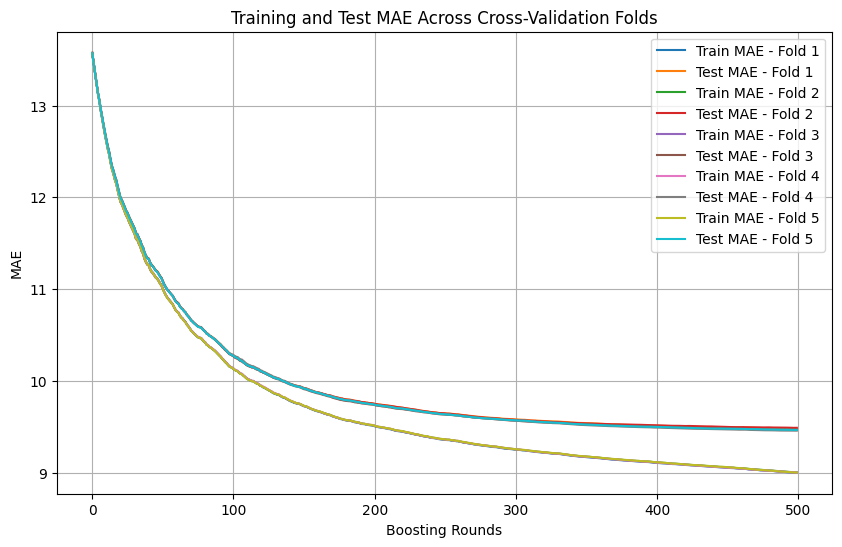

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for i in range(repeat_cv):
    plt.plot(xgb_cv[i]['train-mae-mean'], label=f'Train MAE - Fold {i+1}')
    plt.plot(xgb_cv[i]['test-mae-mean'], label=f'Test MAE - Fold {i+1}')

plt.title("Training and Test MAE Across Cross-Validation Folds")
plt.xlabel("Boosting Rounds")
plt.ylabel("MAE")
plt.legend(loc="best")
plt.grid(True)
plt.show()


# 10 most important features (definitely need to feature engineer)

/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:02:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 1000x800 with 0 Axes>

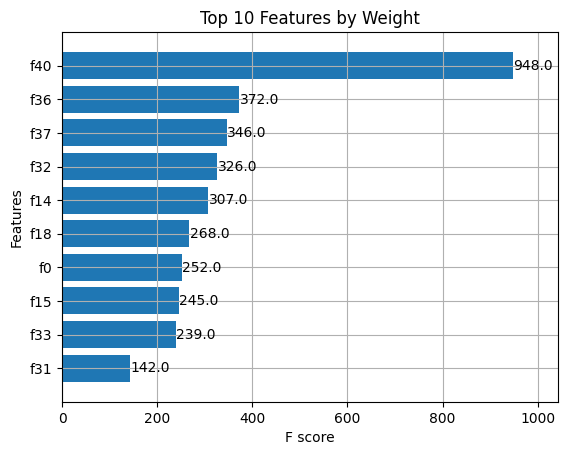

In [43]:
best_num_boost_round = xgb_cv[2].shape[0] 

model = xgb.train(param, dtrain, num_boost_round=best_num_boost_round)

# Plot feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, importance_type='weight', max_num_features=10, height=0.8)
plt.title("Top 10 Features by Weight")
plt.show()

In [44]:
importance = model.get_score(importance_type='weight')

sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
print("Top 10 Features by Importance:")
for feature, score in sorted_importance[:10]:
    print(f"{feature}: {score}")


Top 10 Features by Importance:
f40: 948.0
f36: 372.0
f37: 346.0
f32: 326.0
f14: 307.0
f18: 268.0
f0: 252.0
f15: 245.0
f33: 239.0
f31: 142.0


# Learning curve

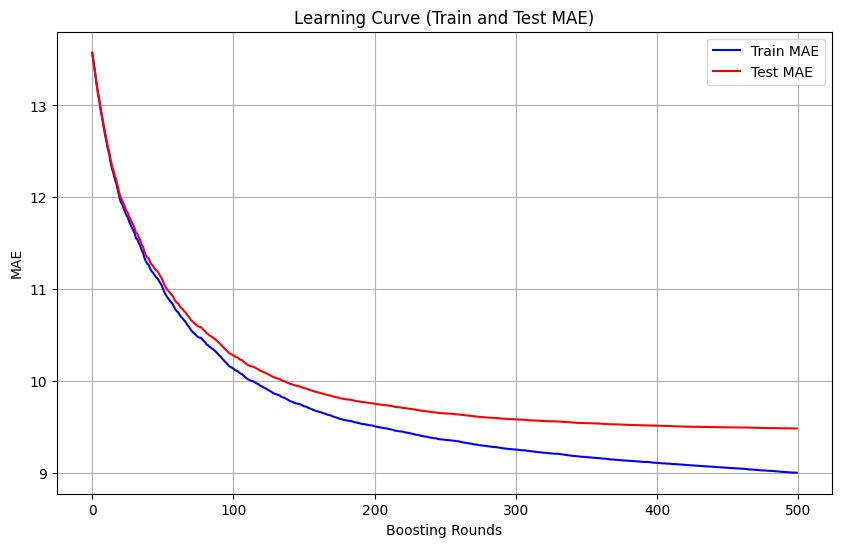

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(xgb_cv[0]['train-mae-mean'], label='Train MAE', color='blue')
plt.plot(xgb_cv[0]['test-mae-mean'], label='Test MAE', color='red')
plt.title("Learning Curve (Train and Test MAE)")
plt.xlabel("Boosting Rounds")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.show()

In [46]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]

oof_preds = []
for i in range(repeat_cv):
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:03:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/fg/_cm9z0lx34b9zrpmj_h8s3q80000gn/T/ipykernel_61122/2329130935.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.14389801e+01  9.22519112e+00  3.54958105e+00  1.86236744e+01
  1.03801193e+01 -8.11185002e-01  8.87146091e+00 -6.09328842e+00
 -4.49880695e+00 -2.43753195e+00 -3.81147075e+00 -1.65013433e+00
  6.04185820e+00  1.70745206e+00  1.83539371e+01  2.99504519e+00
  4.21568823e+00  6.86586738e-01 -2.13705611e+00  8.59294128e+00
  1.79282246e+01 -9.59941208e-01  4.36310816e+00  2.79924965e+01
  8.60815239e+00 -1.61953211e+00  2.04249859e+01  5.87173748e+00
  1.15362015e+01  2.90975690e+00  1.23457546e+01 -3.24624062e+00
  5.421658

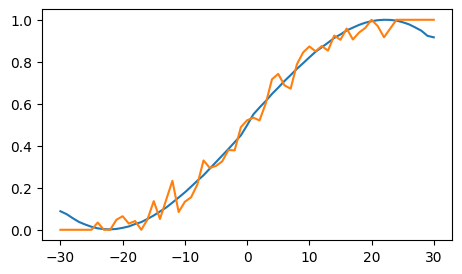

In [47]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))


plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int').mean().reset_index()

plt.figure(figsize=[5.3,3.0])
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

# Preparing output for submission

In [48]:
sampleSub2 = pd.read_csv("../../data/SampleSubmissionStage2.csv")
print(f"sampleSub2.shape: {sampleSub2.shape}")

sampleSub2['Season'] = sampleSub2['ID'].apply(lambda x: int(x.split('_')[0]))
sampleSub2["T1_TeamID"] = sampleSub2['ID'].apply(lambda x: int(x.split('_')[1]))
sampleSub2["T2_TeamID"] = sampleSub2['ID'].apply(lambda x: int(x.split('_')[2]))

print(f"season_statistics T1.shape: {season_statistics_T1.shape}")
sampleSub2 = pd.merge(sampleSub2, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
print(f"season_statistics T2.shape: {season_statistics_T2.shape}")
sampleSub2 = pd.merge(sampleSub2, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

print(f"glm_eloT1.shape: {glm_elo_T1.shape}")
sampleSub2 = pd.merge(sampleSub2, glm_elo_T1, on = ['Season', 'T1_TeamID'], how = 'left')
print(f"glm_eloT2.shape: {glm_elo_T2.shape}")
sampleSub2 = pd.merge(sampleSub2, glm_elo_T2, on = ['Season', 'T2_TeamID'], how = 'left')

print(f"seeds_T1.shape: {seeds_T1.shape}")
sampleSub2 = pd.merge(sampleSub2, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
print(f"seeds_T2.shape: {seeds_T2.shape}")
sampleSub2 = pd.merge(sampleSub2, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

print(f"last60days_stats_T1.shape: {last60days_stats_T1.shape}")
sampleSub2 = pd.merge(sampleSub2, last60days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
print(f"last60days_stats_T2.shape: {last60days_stats_T2.shape}")
sampleSub2 = pd.merge(sampleSub2, last60days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sampleSub2["Seed_diff"] = sampleSub2["T1_seed"] - sampleSub2["T2_seed"]

Xsub = sampleSub2[features].values
Xsub_scaled = scaler.transform(Xsub)  
dtest = xgb.DMatrix(Xsub_scaled)


sub_models = []
for i in range(repeat_cv):
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    
sampleSub2["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)
sampleSub2[['ID','Pred']].to_csv("../../submissions/NER.csv", index = None)


sampleSub2.shape: (131407, 2)
season_statistics T1.shape: (13583, 20)
season_statistics T2.shape: (13583, 20)
glm_eloT1.shape: (1682, 3)
glm_eloT2.shape: (1682, 3)
seeds_T1.shape: (4370, 3)
seeds_T2.shape: (4370, 3)
last60days_stats_T1.shape: (13573, 3)
last60days_stats_T2.shape: (13573, 3)


/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:15:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:15:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:16:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/danchizik/Desktop/marchMadness/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:17:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  w

In [49]:
teams = pd.read_csv('../../data/MTeams.csv')  
MTeam_spellings = pd.read_csv('../../data/MTeamspellings.csv', encoding='ISO-8859-1')  
WTeam_spellings = pd.read_csv('../../data/WTeamspellings.csv', encoding='ISO-8859-1')  
teams_spelling = pd.concat([MTeam_spellings, WTeam_spellings])
teams_spelling = teams_spelling.groupby(by='TeamID', as_index=False)['TeamNameSpelling'].count()
teams_spelling.columns = ['TeamID', 'TeamNameCount']
teams = pd.merge(teams, teams_spelling, how='left', on=['TeamID'])
teams.head()

,TeamID,TeamName,FirstD1Season,LastD1Season,TeamNameCount
0,1101,Abilene Chr,2014,2025,3
1,1102,Air Force,1985,2025,2
2,1103,Akron,1985,2025,1
3,1104,Alabama,1985,2025,1
4,1105,Alabama A&M,2000,2025,2


In [50]:
merged_df = sampleSub2.merge(teams, left_on="T1_TeamID", right_on="TeamID", how="left")
merged_df = merged_df.rename(columns={"TeamName": "Team1_Name"}).drop(columns=["TeamID"])


merged_df = merged_df.merge(teams, left_on="T2_TeamID", right_on="TeamID", how="left")
merged_df = merged_df.rename(columns={"TeamName": "Team2_Name"}).drop(columns=["TeamID"])

merged_df.sample(20)
merged_df.to_csv("../../submissions/NER_full_col_submission.csv", index = None)
